In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import quantumsolver as qs

# help(qs.fewnucleonEmulator)

# Vectorized version of the fewnucleonEmulator
vfewnucleonEmulator = np.vectorize(qs.fewnucleonEmulator)


In [2]:
# LaTeX font
plt.style.use('default')
plt.rc('text', usetex = True)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
font_size = 14
plt.rcParams['font.size'] = font_size

cD_grid = np.linspace(-2.5, 2.5, 100)
cE_grid = np.linspace(-1., 1., 100)

# Create a 2-dimensional grid
cD_eval, cE_eval = np.meshgrid(cD_grid,cE_grid)


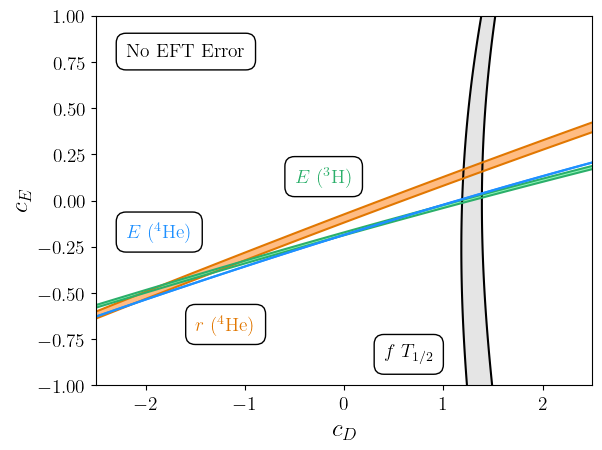

In [3]:

def constraint_plotter(cD_eval, cE_eval, efterror=False):

    E4He_eval, Rp4He_eval, _, E3He_eval, E3H_eval, _, fT3H_eval = vfewnucleonEmulator(cD_eval, cE_eval)
            
    fig, ax = plt.subplots()

    x = 1

    mean_E4He = -28.296 # np.mean(E4He_eval)
    mean_Rp4He = 1.4552  # np.mean(Rp4He_eval)
    mean_E3H = -8.482 # np.mean(E3H_eval) 
    mean_fT3H = 1129.6 #np.mean(fT3H_eval)

    sigma_E3H = 0.015
    sigma_E4He = 0.005
    sigma_Rp4He = 0.0062
    sigma_fT3H = 3.

    if efterror:
        sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
        sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
        sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
        sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))
        ax.text(-2.2, 0.7, 'With EFT Error \n $\\bar{c}=1$, $Q=0.33$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    else:
        ax.text(-2.2, 0.78, 'No EFT Error', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)

    cs = ax.contourf(cD_eval, cE_eval, fT3H_eval, levels=[mean_fT3H-x*sigma_fT3H, mean_fT3H+x*sigma_fT3H], colors='gray', alpha=0.2)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='black')
    cs = ax.contourf(cD_eval, cE_eval, Rp4He_eval, levels=[mean_Rp4He-x*sigma_Rp4He, mean_Rp4He+x*sigma_Rp4He], colors='#ffb16d', alpha=0.85)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#e17701')
    cs = ax.contourf(cD_eval, cE_eval, E3H_eval, levels=[mean_E3H-x*sigma_E3H, mean_E3H+x*sigma_E3H], colors='#7af9ab', alpha=0.8)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='#2baf6a', linestyles='-')
    cs = ax.contourf(cD_eval, cE_eval, E4He_eval, levels=[mean_E4He-x*sigma_E4He, mean_E4He+x*sigma_E4He], colors='dodgerblue', alpha=0.5)
    contour_lines = ax.contour(cs, levels=cs.levels[:3], colors='dodgerblue', linestyles='-')

    return ax

def customizer(ax):

    ax.set_xlabel('$c_D$', fontsize=font_size+4)
    ax.set_ylabel('$c_E$', fontsize=font_size+4)
    ax.text(0.4, -0.85, '$f$ $T_{1/2}$', color='black', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-1.5, -0.7, '$r$ ($^4$He)', color='#e17701', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-0.5, .1, '$E$ ($^3$H)', color='#2baf6a', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.text(-2.2, -0.2, '$E$ ($^4$He)', color='dodgerblue', 
        bbox=dict(facecolor='none', edgecolor='black', boxstyle='round,pad=0.5'), fontsize=font_size)
    ax.tick_params(axis='x', labelsize=font_size)
    ax.tick_params(axis='y', labelsize=font_size)

save = False
efterror = False

### Comment after one use for customization of text boxes by changing
### the customizer function
ax = constraint_plotter(cD_eval, cE_eval, efterror=efterror)

for txt in ax.texts[1:]:
    txt.set_visible(False)
    ax.texts[1:].remove(txt)

customizer(ax)

fig = ax.get_figure()
if efterror and save:
    fig.savefig('figs/constraints_EFT_exp.pdf', bbox_inches='tight')
elif save:
    fig.savefig('figs/constraints_noEFT_exp.pdf', bbox_inches='tight')


In [4]:
import emcee
import scipy.stats as stats
import corner

sigma_E3H = np.sqrt(0.015 + (1 * 0.33**4 * -8.482)**2/(1 - 0.33**2))
sigma_E4He = np.sqrt(0.005 + (1 * 0.33**4 * -28.296)**2/(1 - 0.33**2))
sigma_Rp4He = np.sqrt(0.0062 + (1 * 0.33**4 * 1.4552)**2/(1 - 0.33**2))
sigma_fT3H = np.sqrt(3. + (1 * 0.33**4 * 1129.6)**2/(1 - 0.33**2))

def log_prior(params):
    
    cD, cE = params
    cD_mu = 0.
    cD_sigma = 5
    cE_mu = 0.
    cE_sigma = 5

    return (np.sum(stats.norm.logpdf(cD, loc=cD_mu, scale=cD_sigma)) + 
            np.sum(stats.norm.logpdf(cE, loc=cE_mu, scale=cE_sigma)))   

def log_likelihood(params, data_set):
    cD, cE = params
    E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

    # mean_E4He = np.mean(E4He) # -28.296
    # mean_Rp4He = np.mean(Rp4He) # 1.4552
    # mean_E3H = np.mean(E3H) # -8.482
    # mean_fT3H = np.mean(fT3H) # 1129.6

    if len(data_set) == 2:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) + 
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)))
    elif len(data_set) == 4:
        return (np.sum(stats.norm.logpdf(E4He, -28.296, sigma_E4He)) +
                np.sum(stats.norm.logpdf(Rp4He, 1.4552, sigma_Rp4He)) +
                np.sum(stats.norm.logpdf(E3H, -8.482, sigma_E3H)) +
                np.sum(stats.norm.logpdf(fT3H, 1129.6, sigma_fT3H)))

def log_posterior(params, data_set):
    return log_prior(params) + log_likelihood(params, data_set)

cD = np.random.normal(0., 5, 32)
cE = np.random.normal(0., 5, 32)

pos = np.vstack((cD, cE))
nwalkers, ndim = pos.T.shape

E4He, Rp4He, _, _, E3H, _, fT3H = vfewnucleonEmulator(cD, cE)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob_fn=log_posterior, args=[(E4He, Rp4He, E3H, fT3H)])
new_pos, prob, state = sampler.run_mcmc(pos.T, 100, progress=True)
sampler.reset()

run = sampler.run_mcmc(new_pos, 1000, progress=True)

100%|██████████| 1000/1000 [00:55<00:00, 17.95it/s]


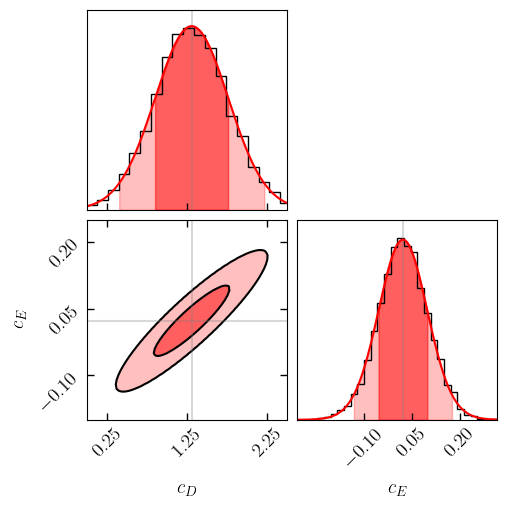

In [5]:

flat_samples = sampler.get_chain(discard=100, thin=1, flat=True)
fig = corner.corner(flat_samples, labels=[r"$c_D$", r"$c_E$"], color='k',
                show_titles=False, bins=30, plot_contours=False, plot_datapoints=False, 
                plot_density=False)#, levels=[0.68, 0.95])

for i in range(flat_samples.shape[1]+1):
    if i < 2:
        ### Diagonal indices of the corner plot
        ax = fig.get_axes()[i * (len(flat_samples[1]) + 1)]

        ### Each 'poly' is a Polygon object; we can extract the vertices
        verts = ax.patches[0].get_xy()

        ### The x-values represent the bin edges, y-values represent the heights
        bin_left_edges = verts[:, 0]
        bin_heights = verts[:, 1]
        bin_width = np.diff(bin_left_edges)[1]

        ### Fit a t-distribution to the histogram data
        df, loc, scale = stats.t.fit(flat_samples[:, i])
        ax.axvline(loc, color='gray', linestyle='-', alpha=0.3)

        ### Eftersom df blir stor tror jag att det är bättre att använda normalfördelning ###

        ### Total histogram area
        area = np.sum(bin_width/2 * bin_heights)

        ### Generate the t-distribution PDF using the fitted parameters
        x = np.linspace(bin_left_edges.min(), bin_left_edges.max(), 1000)
        pdf_fitted = stats.t.pdf(x, df, loc=loc, scale=scale) * area
        ### Plot the t-distribution PDF over the histogram
        ax.plot(x, pdf_fitted, 'r-')
        ax.set_xticks([loc-scale*2, loc, loc+scale*2])

        if i == 0:
            ax.set_xticks([0.25, 1.25, 2.25])
            ax.set_xlim(0, 2.5)
            ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')
        else:
            ax.set_xticks([-0.1, 0.05, 0.2])
            ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

        def fill(cred_region, alpha):
            t_value_lower = stats.t.ppf(1-(1+cred_region)/2, df=df, loc=loc, scale=scale)
            t_value_upper = stats.t.ppf((1+cred_region)/2, df=df, loc=loc, scale=scale)
            ax.fill_between(x, pdf_fitted, where=((x >= t_value_lower) & (x <= t_value_upper)), 
                        color='r', alpha=alpha)
        
        fill(0.95, 0.25)
        fill(0.68, 0.5)
    else:
        contour_ax = fig.get_axes()[2]

        mv_fit = stats.multivariate_normal.fit(flat_samples)
        mv_means = mv_fit[0]
        mv_cov = mv_fit[1]

        x, y = np.mgrid[-2.5:2.5:.01, -1:1:.01]
        pos = np.dstack((x, y))

        mv_pdf = stats.multivariate_normal(mean=mv_means, cov=mv_cov)
        test = mv_pdf.pdf((mv_means[0], mv_means[1]))
        test_sigma = mv_pdf.pdf((mv_means[0]-np.sqrt(mv_cov[0, 0]), mv_means[1]-np.sqrt(mv_cov[1, 1])))
        test_2sigma = mv_pdf.pdf((mv_means[0]-2*np.sqrt(mv_cov[0, 0]), mv_means[1]-2*np.sqrt(mv_cov[1, 1])))
        
        lines1 = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=[test_2sigma, test], colors='r', alpha=0.25)
        lines2 = contour_ax.contourf(x, y, mv_pdf.pdf(pos), levels=[test_sigma, test], colors='r', alpha=0.5)
        contour_ax.contour(lines1, levels=lines1.levels[:1], colors='k')
        contour_ax.contour(lines2, levels=lines2.levels[:1], colors='k')

        contour_ax.set_xlim(0, 2.5)
        contour_ax.set_ylim(-0.2, 0.25)

        contour_ax.set_xticks([0.25, 1.25, 2.25])
        contour_ax.set_yticks([-0.1, 0.05, 0.2])
        contour_ax.yaxis.set_ticks_position('both')
        contour_ax.xaxis.set_ticks_position('both')
        contour_ax.tick_params(axis='both', direction='in', length=5, width=1, colors='black')

        contour_ax.axhline(mv_means[1], color='gray', linestyle='-', alpha=0.3)
        contour_ax.axvline(mv_means[0], color='gray', linestyle='-', alpha=0.3)
    
# fig, axes = plt.subplots(2, figsize=(8, 6), sharex=True)

# # Plot trace för cD (första parametern)
# axes[0].plot(samples[:, :, 0], "k", alpha=0.3)
# axes[0].set_title("Trace plot for cD")
# axes[0].set_ylabel("cD")

# # Plot trace för cE (andra parametern)
# axes[1].plot(samples[:, :, 1], "k", alpha=0.3)
# axes[1].set_title("Trace plot for cE")
# axes[1].set_ylabel("cE")
# axes[1].set_xlabel("Iteration")

plt.show()